In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "flow_ss_mse"
ood = "5:6:7:8:9"

In [3]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

100%|██████████| 10000/10000 [00:00<00:00, 67965.23it/s]


In [4]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [5]:
# model ids
model_ids = {
    "": "anakuj64",
    "0:1:2:3:4": 'eblizrz6',
    "5:6:7:8:9": "lolh8tr4",
}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

5:6:7:8:9 lolh8tr4


In [6]:
model = config.get_model()

In [7]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
from models.common import edl_probs
from tqdm import tqdm

ind_u = []
ind_v = []
if ood_str:
    ood_u = []
    ood_v = []

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (u, v), (u_norm, v_norm), x_m, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (u, v), (u_norm, v_norm), x_m, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (u, v), (u_norm, v_norm), x_m, logits = model(x)
    ind_u.extend(u.detach().cpu().numpy())
    ind_v.extend(v.detach().cpu().numpy())
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (u, v), (u_norm, v_norm), x_m, logits = model(x)
        ood_u.extend(u.detach().cpu().numpy())
        ood_v.extend(v.detach().cpu().numpy())
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    (u, v), (u_norm, v_norm), x_m, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

ind_u = np.array(ind_u).squeeze()
ind_v = np.array(ind_v).squeeze()
if ood_str:
    ood_u = np.array(ood_u).squeeze()
    ood_v = np.array(ood_v).squeeze()

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

100%|██████████| 383/383 [00:14<00:00, 26.40it/s]


train - OK


100%|██████████| 96/96 [00:03<00:00, 26.27it/s]


val - OK


100%|██████████| 81/81 [00:03<00:00, 26.60it/s]


test InD - OK


100%|██████████| 536/536 [00:19<00:00, 27.42it/s]


test OoD - OK


100%|██████████| 100/100 [00:03<00:00, 31.62it/s]


test RnD - OK
(24476,) (24476,)
(6120,) (6120,)
(5139,) (5139,)
(34265,) (34265,)
(6400,) (6400,)


In [10]:
from tsnecuda import TSNE

n = ind_u.shape[0]

if ood_str:
    all_u = np.concatenate([ind_u, ood_u], axis=0)
    all_v = np.concatenate([ind_v, ood_v], axis=0)
else:
    all_u = ind_u
    all_v = ind_v

emb2d_u = TSNE(n_components=2, perplexity=100, random_seed=42).fit_transform(all_u)
emb2d_v = TSNE(n_components=2, perplexity=100, random_seed=42).fit_transform(all_v)
ind_u_e2d = emb2d_u[:n]
ind_v_e2d = emb2d_v[:n]
print(ind_u_e2d.shape, ind_v_e2d.shape)

if ood_str:
    ood_u_e2d = emb2d_u[n:]
    ood_v_e2d = emb2d_v[n:]
    print(ood_u_e2d.shape, ood_v_e2d.shape)

(5139, 2) (5139, 2)
(34265, 2) (34265, 2)


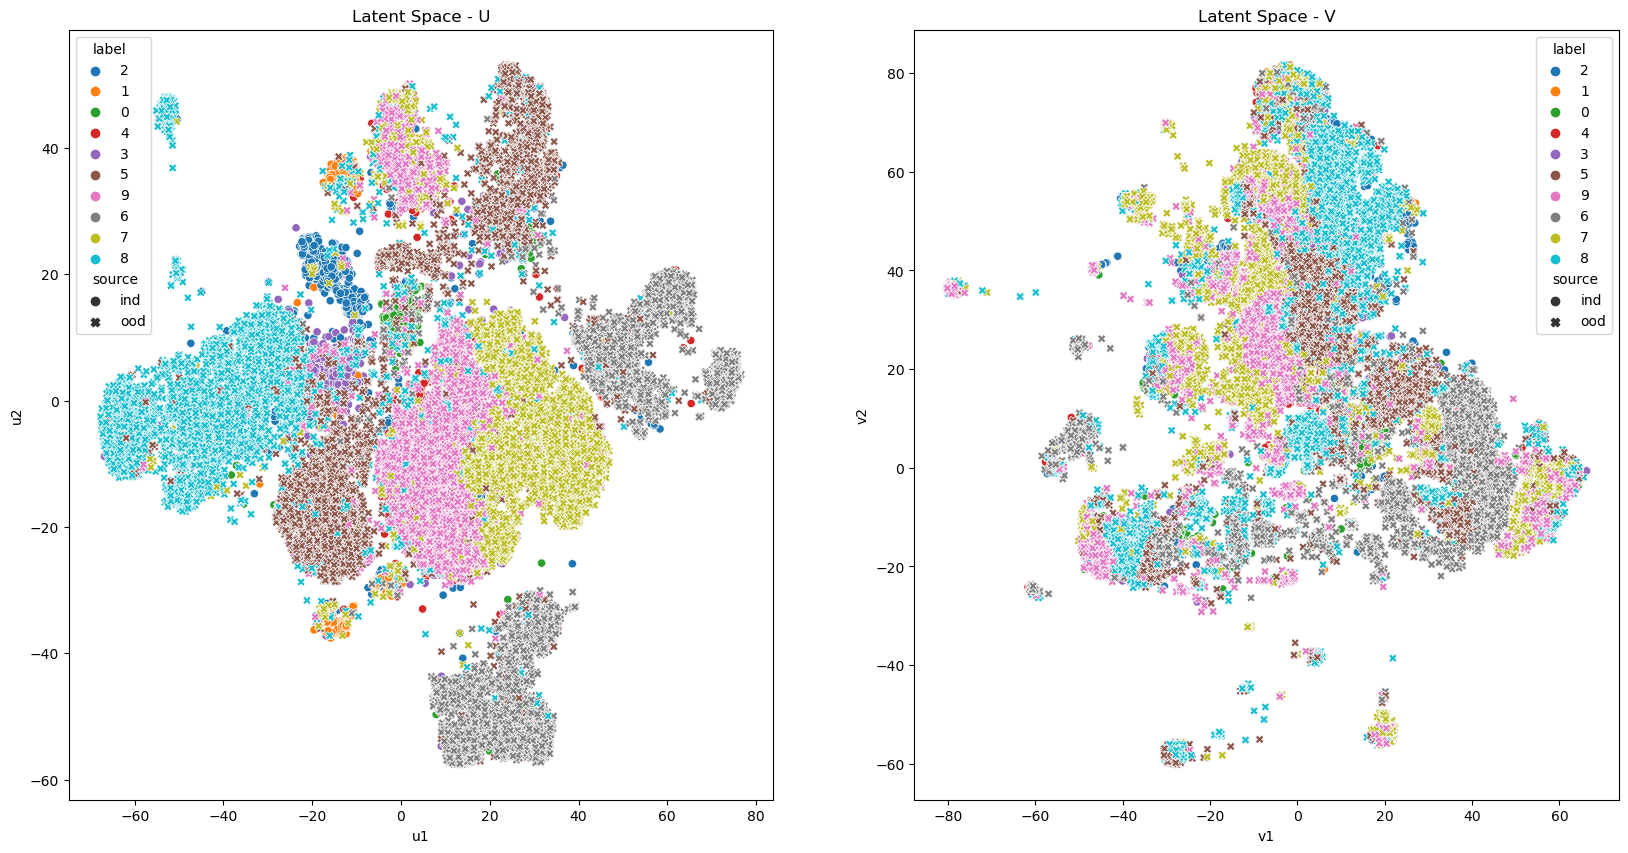

In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_targets]
ood_labels = [config.labels[i] for i in ood_targets]

emb_data = pd.DataFrame()
u1, u2 = ind_u_e2d.T
v1, v2 = ind_v_e2d.T
emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

u1, u2 = ood_u_e2d.T
v1, v2 = ood_v_e2d.T
emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title("Latent Space - U")
ax2.set_title("Latent Space - V")

sns.scatterplot(data=emb_data, x="u1", y="u2", style="source", hue="label", ax=ax1)
sns.scatterplot(data=emb_data, x="v1", y="v2", style="source", hue="label", ax=ax2)
plt.show()

100%|██████████| 4/4 [00:13<00:00,  3.37s/it]


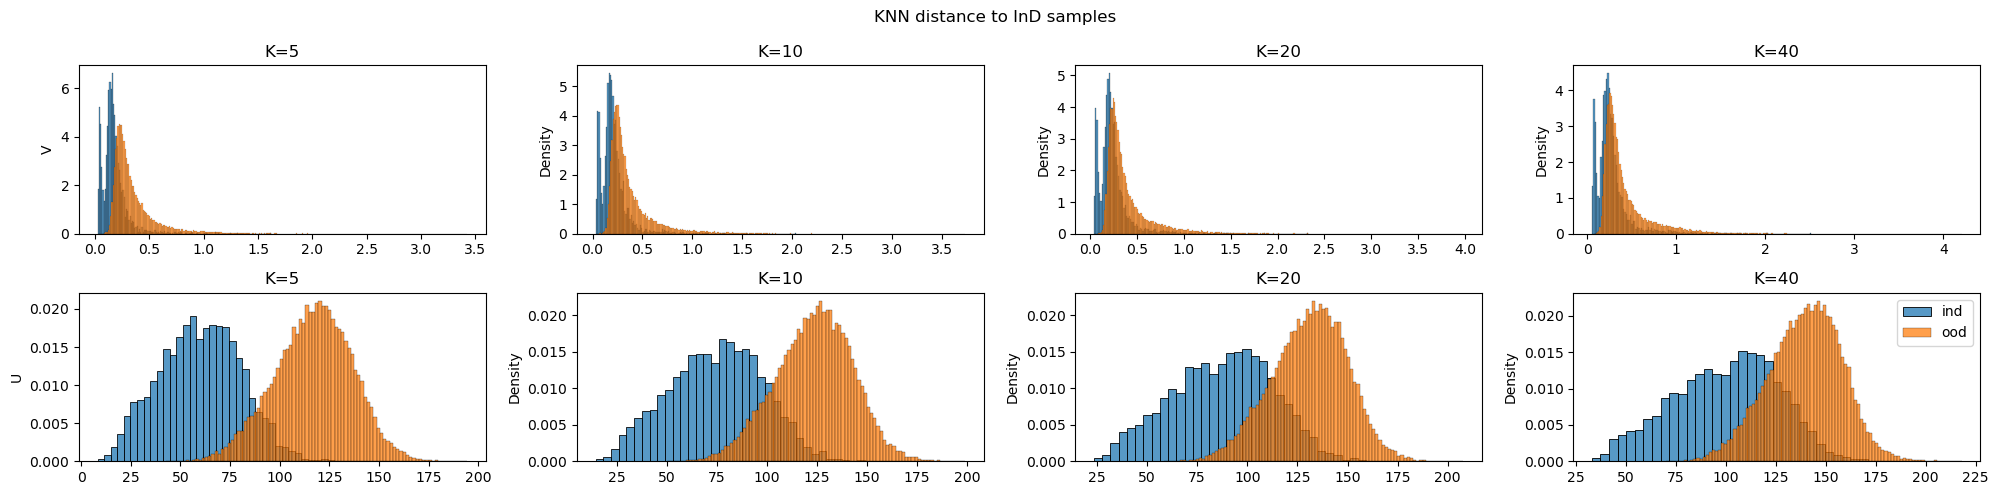

In [13]:
import faiss

index_v = faiss.IndexFlatL2(ind_v.shape[-1])
index_v.add(ind_v)

index_u = faiss.IndexFlatL2(ind_u.shape[-1])
index_u.add(ind_u)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 5))
fig.suptitle("KNN distance to InD samples")

axs[0][0].set_ylabel("V")
axs[1][0].set_ylabel("U")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    
    # from V
    Di, _ = index_v.search(ind_v, k)
    Do, _ = index_v.search(ood_v, k)
    ax = axs[0][j]
    ax.set_title(f"K={k}")
    sns.histplot(Di.mean(-1), fill=True, label='ind', stat='density', ax=ax)
    sns.histplot(Do.mean(-1), fill=True, label='ood', stat='density', ax=ax)
    
    # from U
    Di, _ = index_u.search(ind_u, k)
    Do, _ = index_u.search(ood_u, k)
    ax = axs[1][j]
    ax.set_title(f"K={k}")
    sns.histplot(Di.mean(-1), fill=True, label='ind', stat='density', ax=ax)
    sns.histplot(Do.mean(-1), fill=True, label='ood', stat='density', ax=ax)

plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 4/4 [00:11<00:00,  2.92s/it]


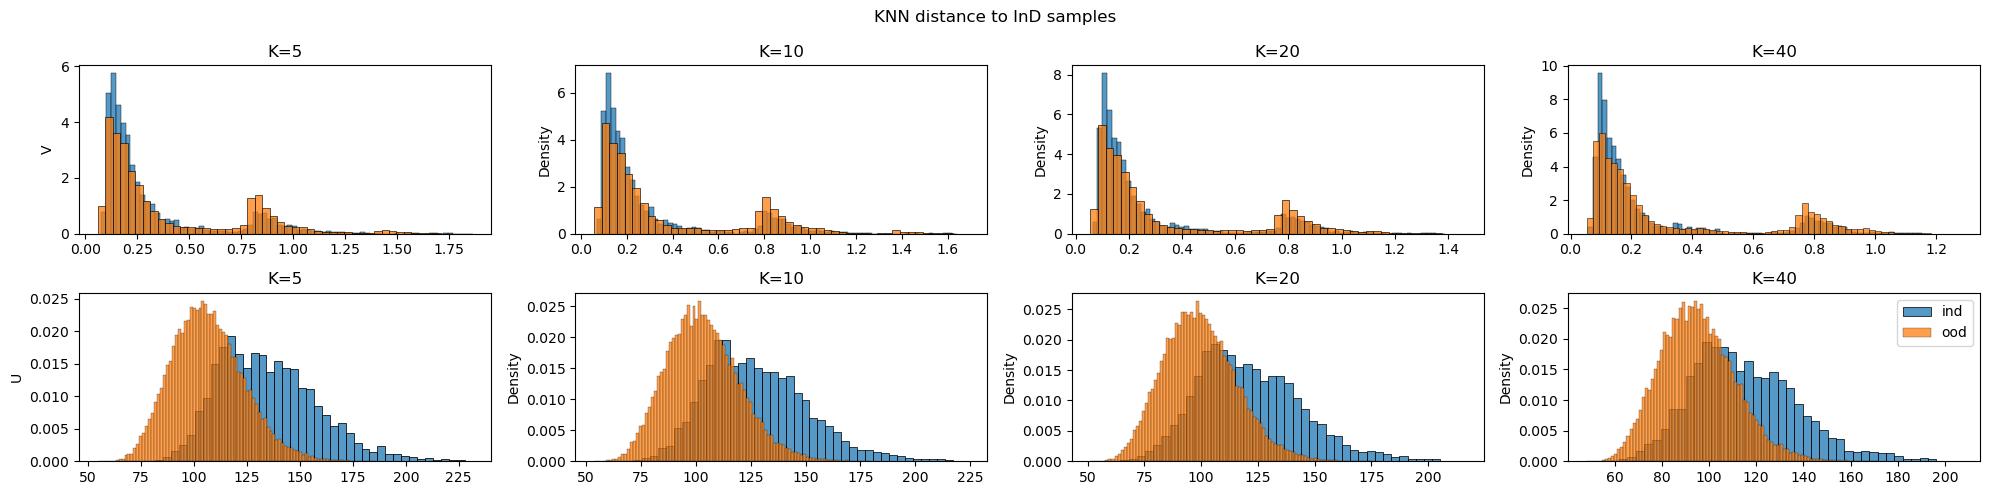

In [14]:
import faiss

norm_ind_v = ind_v # / np.linalg.norm(ind_v, axis=-1)[..., None]
norm_ind_u = ind_u #/ np.linalg.norm(ind_u, axis=-1)[..., None]
norm_ood_v = ood_v #/ np.linalg.norm(ood_v, axis=-1)[..., None]
norm_ood_u = ood_u #/ np.linalg.norm(ood_u, axis=-1)[..., None]

index_v = faiss.IndexFlatIP(norm_ind_v.shape[-1])
index_v.add(norm_ind_v)

index_u = faiss.IndexFlatIP(norm_ind_u.shape[-1])
index_u.add(norm_ind_u)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 5))
fig.suptitle("KNN distance to InD samples")

axs[0][0].set_ylabel("V")
axs[1][0].set_ylabel("U")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    
    # from V
    Di, _ = index_v.search(norm_ind_v, k)
    Do, _ = index_v.search(norm_ood_v, k)
    ax = axs[0][j]
    ax.set_title(f"K={k}")
    sns.histplot(Di.mean(-1), fill=True, label='ind', stat='density', ax=ax)
    sns.histplot(Do.mean(-1), fill=True, label='ood', stat='density', ax=ax)
    
    # from U
    Di, _ = index_u.search(norm_ind_u, k)
    Do, _ = index_u.search(norm_ood_u, k)
    ax = axs[1][j]
    ax.set_title(f"K={k}")
    sns.histplot(Di.mean(-1), fill=True, label='ind', stat='density', ax=ax)
    sns.histplot(Do.mean(-1), fill=True, label='ood', stat='density', ax=ax)

plt.legend()
plt.tight_layout()
plt.show()

In [15]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

12.709921 0.92677456
12.696987 0.8919824
12.70836 0.9294918
12.632933 0.68486017
18.997776 1.1774378
0.5919477 0.22652943
0.59385055 0.2294867
0.58538634 0.22488396
0.70999336 0.2656071
24.93874 0.7657794


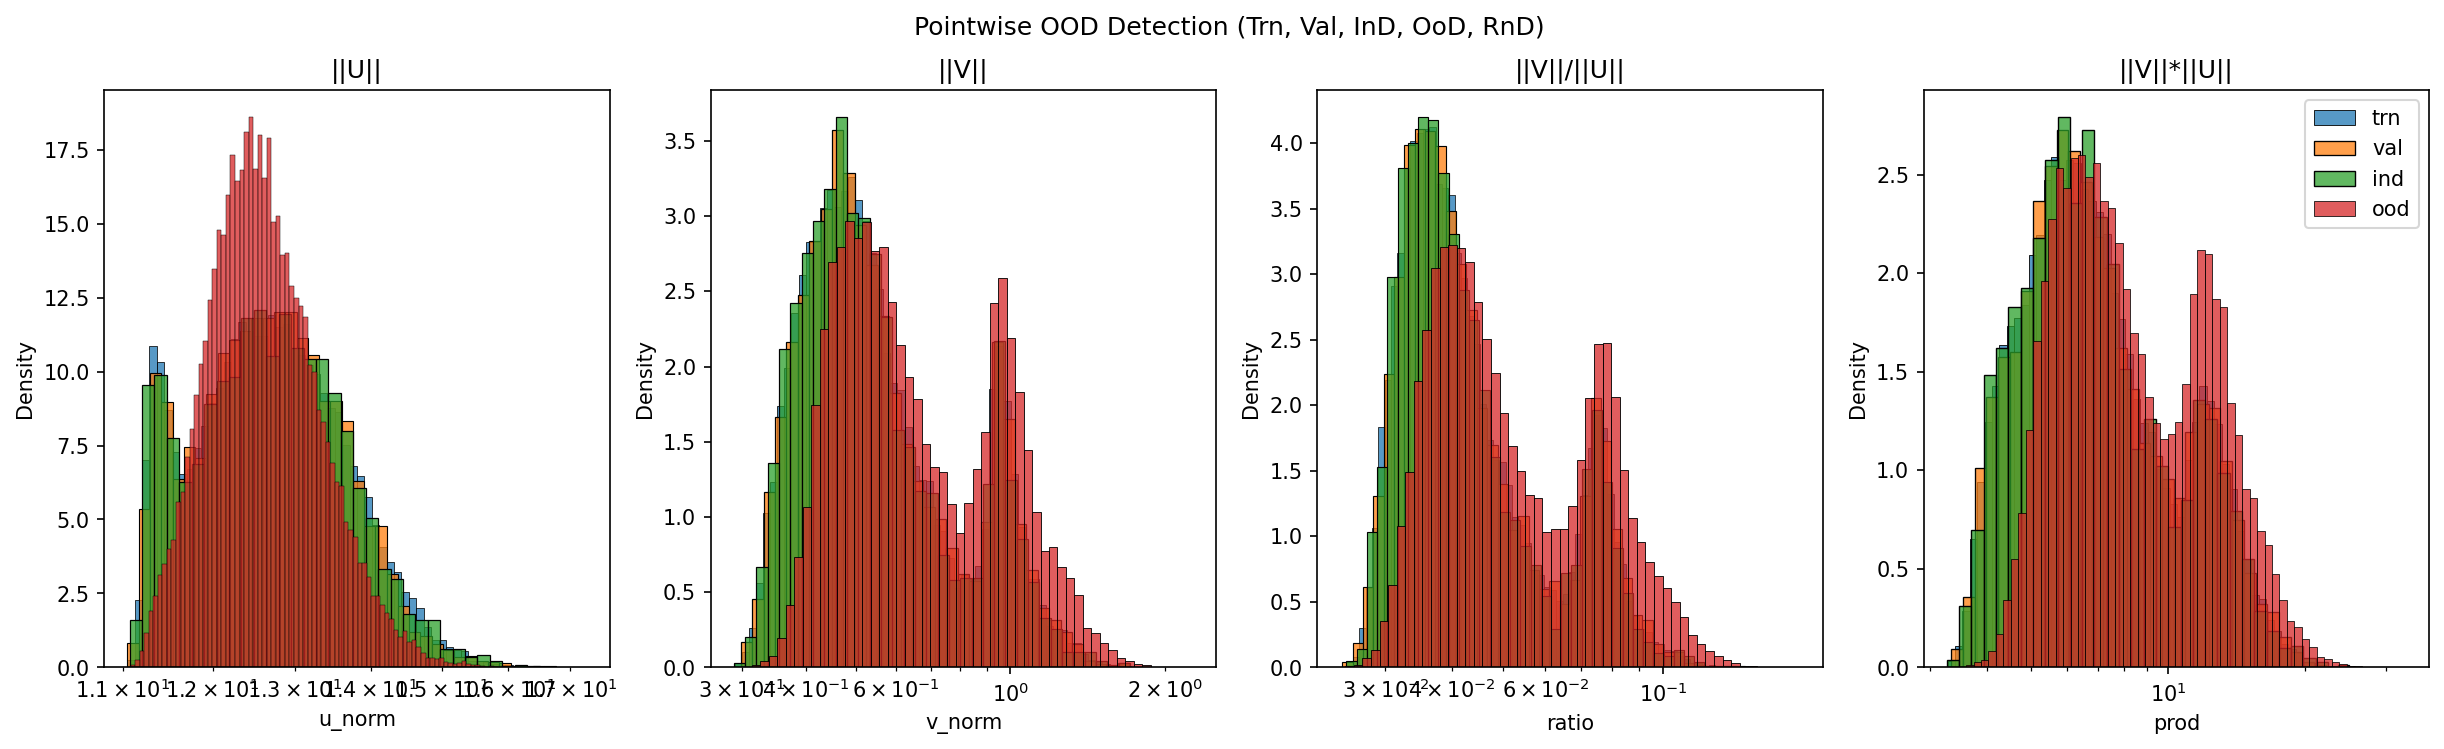

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [17]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 0.2910748 1.9487028 1.657628
Val 0.29870215 1.7041073 1.4054052
Ind 0.2896368 1.7111057 1.421469
Ood 0.3024837 2.272525 1.9700414
Rnd 22.113646 27.50563 5.391985
KstestResult(statistic=0.22415304271303016, pvalue=9.360718675436104e-198, statistic_location=0.54375035, statistic_sign=1)


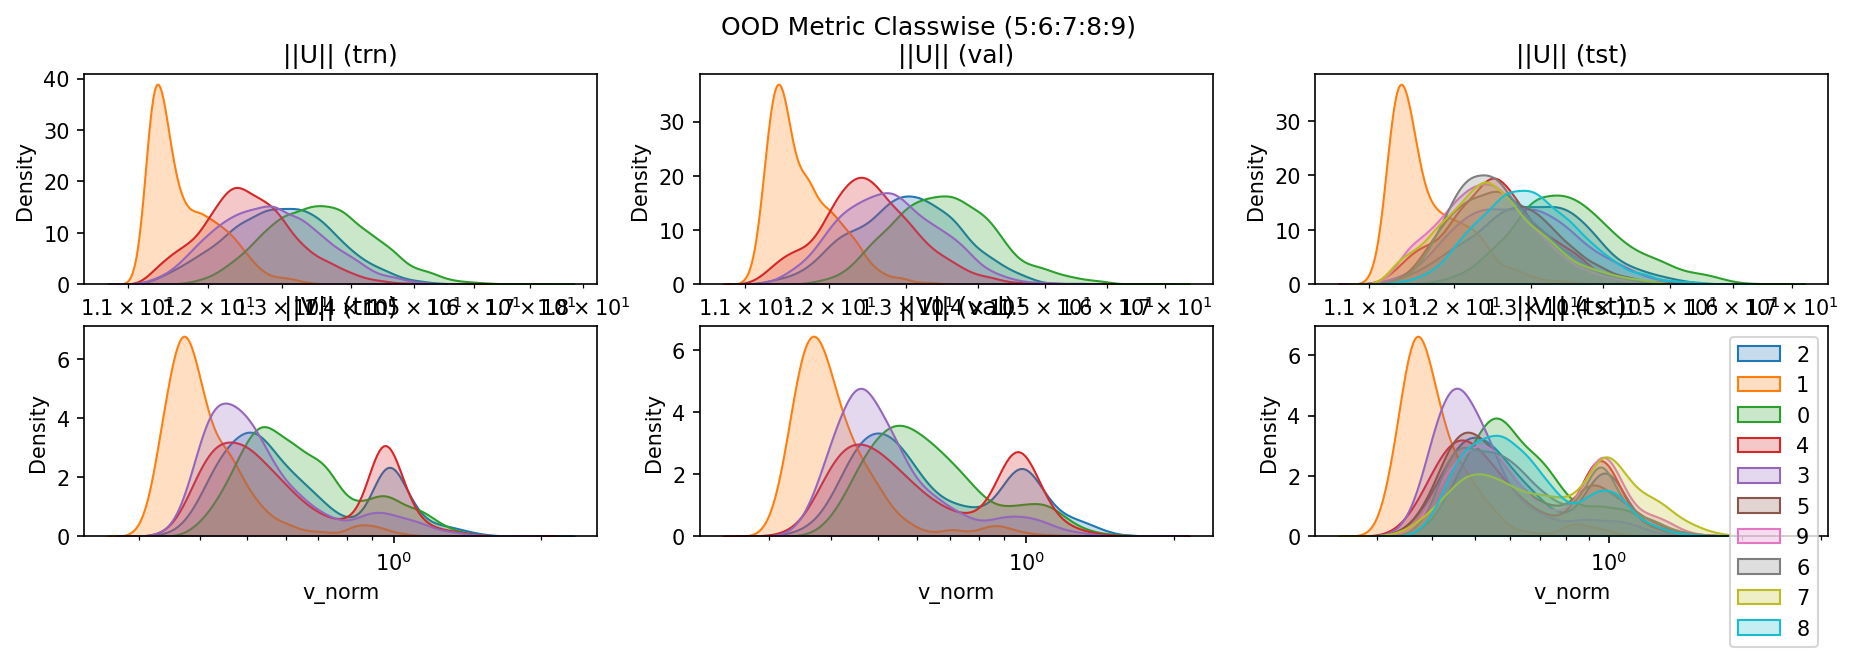

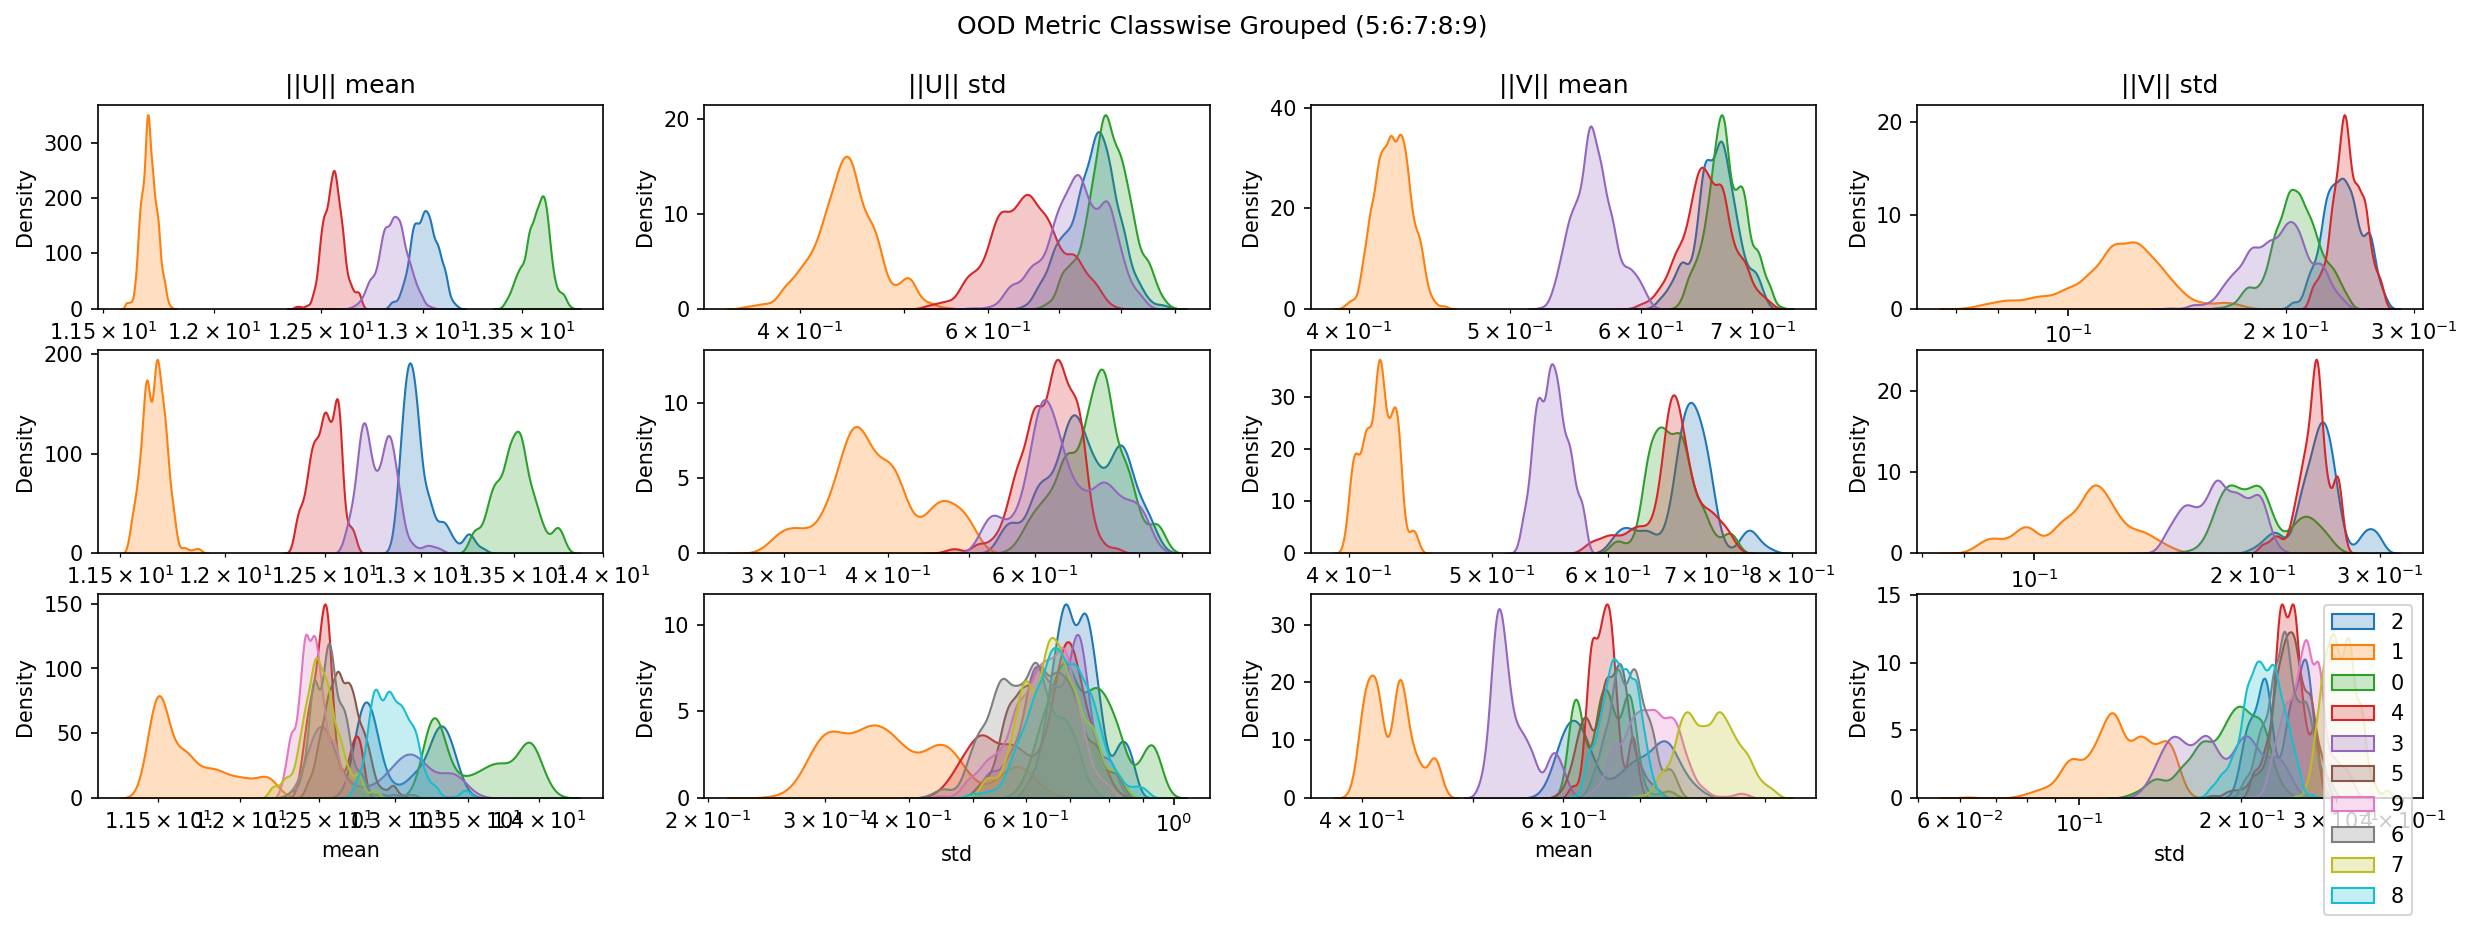

In [18]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
all_targets = list(data_tst['target'].unique())

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in all_targets:
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in all_targets:
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in all_targets:
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [19]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in all_targets:
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)